In [1]:
import PIL
import time
import torch
import torchvision
import torch.nn.functional as F
from einops import rearrange
from torch import nn
import torch.nn.init as init

In [2]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 100

DL_PATH = "./data" # Use your own path
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
transform_train = torchvision.transforms.Compose(
     [torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
     torchvision.transforms.RandomAffine(8, translate=(.15,.15)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

transform_test = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_dataset = torchvision.datasets.CIFAR10(DL_PATH, train=True,
                                        download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(DL_PATH, train=False,
                                        download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST,
                                         shuffle=False)

C:\Users\dmele\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\transforms.py:1200: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(
Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device('cuda')

In [5]:
def train(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data.to(device)), dim=1)
        loss = F.nll_loss(output.to(device), target.to(device))
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())
            
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            target = target.to(device)
            output = F.log_softmax(model(data.to(device)), dim=1).to(device)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [6]:
from ViTResNet import *

In [8]:
N_EPOCHS = 3


model = ViTResNet(BasicBlock, [3, 3, 3]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=.9,weight_decay=1e-4)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[35,48],gamma = 0.1)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    start_time = time.time()
    train(model, optimizer, train_loader, train_loss_history)
    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    evaluate(model, test_loader, test_loss_history)

print('Execution time')

PATH = "./ViTRes.pt" # Use your own path
torch.save(model.state_dict(), PATH)

torch.save(model.state_dict(), "saved_nets/default_from_git.pt")



# =============================================================================
# model = ViT()
# model.load_state_dict(torch.load(PATH))
# model.eval()            
# =============================================================================

Epoch: 1
[    0/50000 (  0%)]  Loss: 5.2817
[10000/50000 ( 20%)]  Loss: 2.2419
[20000/50000 ( 40%)]  Loss: 2.1669
[30000/50000 ( 60%)]  Loss: 2.0003
[40000/50000 ( 80%)]  Loss: 2.0001
Execution time: 27.30 seconds

Average test loss: 1.9862  Accuracy: 1916/10000 (19.16%)

Epoch: 2
[    0/50000 (  0%)]  Loss: 1.8493
[10000/50000 ( 20%)]  Loss: 1.9932
[20000/50000 ( 40%)]  Loss: 2.0414
[30000/50000 ( 60%)]  Loss: 1.7596
[40000/50000 ( 80%)]  Loss: 1.7339
Execution time: 27.29 seconds

Average test loss: 1.7442  Accuracy: 2955/10000 (29.55%)

Epoch: 3
[    0/50000 (  0%)]  Loss: 1.7137
[10000/50000 ( 20%)]  Loss: 1.7430
[20000/50000 ( 40%)]  Loss: 1.7118
[30000/50000 ( 60%)]  Loss: 1.7199
[40000/50000 ( 80%)]  Loss: 1.5064
Execution time: 27.18 seconds

Average test loss: 1.5344  Accuracy: 4017/10000 (40.17%)

Execution time


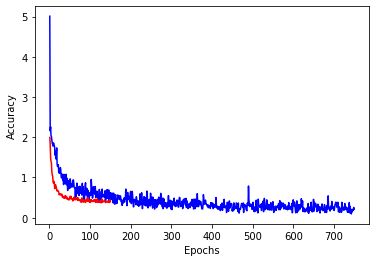

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.xlabel("Loss")
plt.ylabel("Accuracy")

plt.plot(np.arange(1, len(train_loss_history) + 1), train_loss_history, c="b", label="train")
plt.plot(np.arange(1, len(test_loss_history) + 1), test_loss_history, c="r", label="test")
plt.show()


In [17]:
import os

'''
data/dataset_name
metrics/dataset_name/net_name.txt  (epoch, train_accuracy, test_accuracy, test_precision, test_recall)
nets/dataset_name/net_name.pt
nets/dataset_name/net_state.txt (epoch)
graphs/dataset_name/net_name/*

'''

def log_all(dataset_name: str, model: nn.Module, model_name: str, epoch, train_accuracy, test_accuracy, test_precision, test_recall):
    pass

def log_metrics(dataset_name: str, model_name: str, epoch, train_accuracy, test_accuracy, test_precision, test_recall):
    if not os.path.isdir('./metrics'):
        os.mkdir('metrics')
    
    if not os.path.isdir(f'./{dataset_name}'):
        os.mkdir(dataset_name)
    
    metrics = dict()

    with open(f'./metrics/{dataset_name}/{model_name}.txt', 'a') as w:
        
    

